In [7]:
import xarray as xr
import geopandas as gpd
import rioxarray # IMPORTANT: This must be imported to activate the .rio accessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

In [2]:
# --- 2. Define Project Paths ---
# This assumes you are running the notebook from the 'notebooks' directory.
PROJECT_ROOT = Path("../")
RAW_DATA_DIR = PROJECT_ROOT / "data" / "raw"
GIS_DATA_DIR = PROJECT_ROOT / "data" / "gis"
PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"

# Create the output directory if it doesn't exist
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

# Input file paths
NETCDF_FILES = {
    'pr': RAW_DATA_DIR / "PNWNAmet_pr.nc.nc",
    'tasmax': RAW_DATA_DIR / "PNWNAmet_tasmax.nc.nc",
    'tasmin': RAW_DATA_DIR / "PNWNAmet_tasmin.nc.nc",
}
SHAPEFILE_PATH = GIS_DATA_DIR / "Chittenden_catchment.shp"

print(f"Processed data will be saved to: {PROCESSED_DATA_DIR}")

Processed data will be saved to: ..\data\processed


Shapefile loaded successfully.
Basin CRS: EPSG:26910
  NAME           X            Y DESCRIPT  TAG RAINGAGE OUTLET        AREA  \
0   S1  652412.069  5457334.639     None  WDT        *     J2  10895.0306   
1   S2  643804.325  5456575.282     None  WDT        *     J4   5919.9682   
2   S3  630882.928  5455640.404     None  WDT        *     J6  21784.1903   
3   S4  636173.352  5445805.975     None  WDT        *    J18  14291.4835   
4   S5  649985.115  5446906.870     None  WDT        *     J2   9007.9845   

       WIDTH   SLOPE  ...  RUNOFFCOEF  GWEVAP  GWSEEP  GWFLOW  GWMAXFLOW  \
0  10819.587  44.171  ...         0.0     0.0     0.0     0.0        0.0   
1   5834.980  59.841  ...         0.0     0.0     0.0     0.0        0.0   
2  13357.080  63.811  ...         0.0     0.0     0.0     0.0        0.0   
3  15261.581  61.936  ...         0.0     0.0     0.0     0.0        0.0   
4   9750.173  53.499  ...         0.0     0.0     0.0     0.0        0.0   

   GWAVGMOIST GWAVGTABLE  G

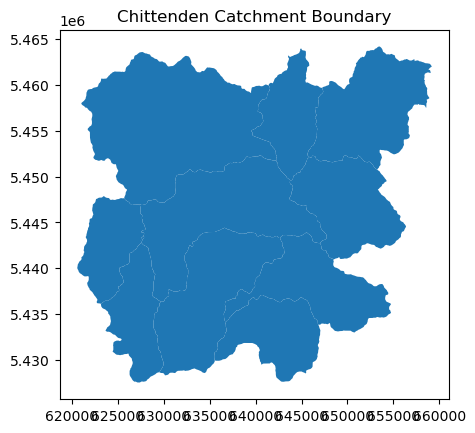

In [3]:
# --- 3. Load and Inspect the Basin Shapefile ---
try:
    basin_gdf = gpd.read_file(SHAPEFILE_PATH)
    print("Shapefile loaded successfully.")
    print("Basin CRS:", basin_gdf.crs)
    
    # Display the first few rows and plot for verification
    print(basin_gdf.head())
    basin_gdf.plot()
    plt.title("Chittenden Catchment Boundary")
    plt.show()

except FileNotFoundError:
    print(f"Error: Shapefile not found at {SHAPEFILE_PATH}")
except Exception as e:
    print(f"An error occurred loading the shapefile: {e}")

In [4]:
# --- 4. Define Clipping Function and Process Data (Ultimate Rebuild Solution) ---

def clip_netcdf_to_shapefile(nc_path, gdf, variable_name, output_path):
    """
    Clips a NetCDF file using the ultimate "rebuild" strategy. This method
    constructs a new dataset from raw NumPy arrays for both the data and all
    coordinates, guaranteeing that no problematic metadata or attributes from
    any component are carried over. This is the definitive fix for the
    persistent "String match to name in use" error.

    Args:
        nc_path (Path): Path to the input NetCDF file.
        gdf (gpd.GeoDataFrame): GeoDataFrame to clip with.
        variable_name (str): The primary data variable name ('pr', 'tasmax', etc.)
        output_path (Path): Path to save the clipped NetCDF file.
    """
    print(f"\n--- Processing {variable_name} ---")
    
    try:
        # Step 1: Open and prepare the dataset for clipping
        ds = xr.open_dataset(nc_path).rio.set_spatial_dims(x_dim="lon", y_dim="lat")
        if ds.rio.crs is None:
            ds.rio.write_crs("EPSG:4326", inplace=True)

        if ds.rio.crs != gdf.crs:
            gdf_reprojected = gdf.to_crs(ds.rio.crs)
        else:
            gdf_reprojected = gdf
        
        # Step 2: Clip the data in memory
        print("Clipping data to basin boundary...")
        clipped_ds_in_memory = ds.rio.clip(gdf_reprojected.geometry, gdf_reprojected.crs, drop=True, all_touched=True)
        
        # Step 3: Rebuild a new, completely clean xarray.Dataset from raw values
        print("Rebuilding a clean dataset from raw values to strip all hidden attributes...")
        
        # Whitelist the safe attributes for the main data variable
        attributes_to_keep = {}
        whitelist = ['long_name', 'units', 'standard_name']
        original_attrs = clipped_ds_in_memory[variable_name].attrs
        for attr_name in whitelist:
            if attr_name in original_attrs:
                attributes_to_keep[attr_name] = original_attrs[attr_name]
        
        # --- THIS IS THE CRITICAL FIX ---
        # Create the new DataArray using only the raw .values of the coordinates.
        # This strips any and all attributes from 'time', 'lat', and 'lon' themselves,
        # which is where the hidden conflict lies.
        clean_data_array = xr.DataArray(
            data=clipped_ds_in_memory[variable_name].values,
            coords={
                'time': ('time', clipped_ds_in_memory['time'].values),
                'lat': ('lat', clipped_ds_in_memory['lat'].values),
                'lon': ('lon', clipped_ds_in_memory['lon'].values)
            },
            dims=('time', 'lat', 'lon'),
            attrs=attributes_to_keep
        )
        # -----------------------------------------------------------------
        
        final_ds_to_save = xr.Dataset({variable_name: clean_data_array})

        # Step 4: Save the newly constructed, pristine dataset
        print(f"Saving the pristine dataset to: {output_path}")
        final_ds_to_save.to_netcdf(output_path)
        
        print(f"Successfully clipped and saved.")
        
        return final_ds_to_save

    except Exception as e:
        import traceback
        print(f"!!! FAILED to process {variable_name}. Error: {e}")
        traceback.print_exc()
        return None

# Loop to run the process for all files
clipped_datasets = {}
for var, path in NETCDF_FILES.items():
    output_filename = f"chittenden_{var}_clipped.nc"
    output_path = PROCESSED_DATA_DIR / output_filename
    
    clipped_data = clip_netcdf_to_shapefile(path, basin_gdf, var, output_path)
    if clipped_data is not None:
        clipped_datasets[var] = clipped_data


--- Processing pr ---
Clipping data to basin boundary...
Rebuilding a clean dataset from raw values to strip all hidden attributes...
Saving the pristine dataset to: ..\data\processed\chittenden_pr_clipped.nc
Successfully clipped and saved.

--- Processing tasmax ---
Clipping data to basin boundary...
Rebuilding a clean dataset from raw values to strip all hidden attributes...
Saving the pristine dataset to: ..\data\processed\chittenden_tasmax_clipped.nc
Successfully clipped and saved.

--- Processing tasmin ---
Clipping data to basin boundary...
Rebuilding a clean dataset from raw values to strip all hidden attributes...
Saving the pristine dataset to: ..\data\processed\chittenden_tasmin_clipped.nc
Successfully clipped and saved.



Verifying the clipped precipitation data...
Reprojecting basin shapefile to EPSG:4326 for plotting...


C:\Users\alex.huang\AppData\Local\Temp\ipykernel_31876\1812929021.py:29: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
C:\Users\alex.huang\AppData\Local\Temp\ipykernel_31876\1812929021.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


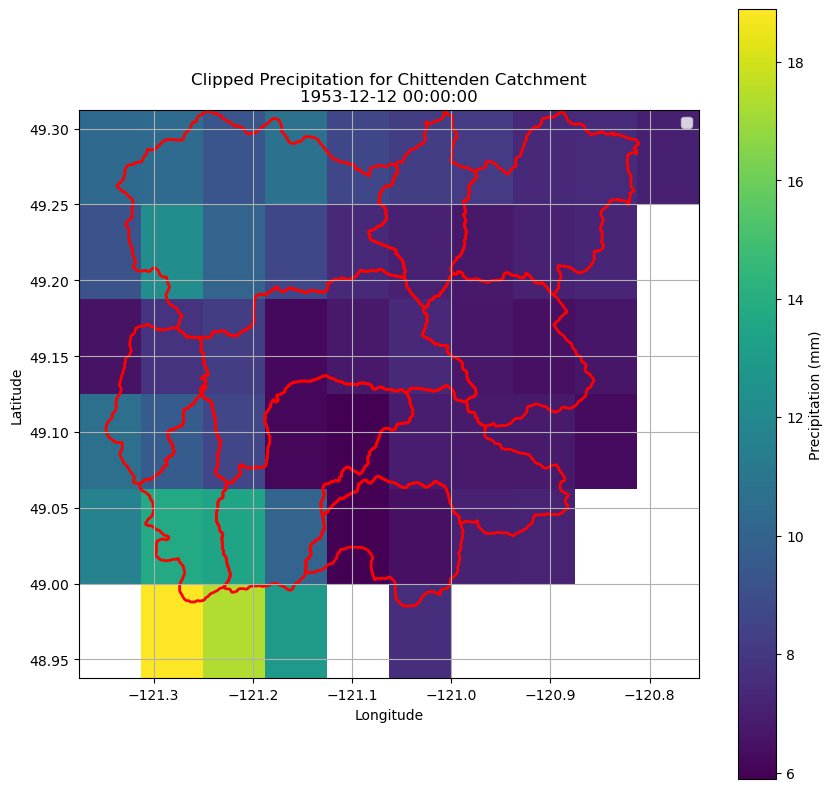

In [8]:
# --- 5. Verify the Clipped Data (Corrected) ---

# Let's verify the precipitation data
if 'pr' in clipped_datasets:
    print("\nVerifying the clipped precipitation data...")
    
    # Select the first time step to plot
    precip_clipped_first_step = clipped_datasets['pr']['pr'].isel(time=0)

    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the clipped raster data
    precip_clipped_first_step.plot(ax=ax, cmap='viridis', cbar_kwargs={'label': 'Precipitation (mm)'})

    # --- THIS IS THE FIX ---
    # Overlay the basin boundary for context.
    # Instead of reading the CRS from the (now clean) raster file,
    # we reproject the shapefile directly to the known CRS of the raster data: EPSG:4326.
    print("Reprojecting basin shapefile to EPSG:4326 for plotting...")
    basin_reprojected = basin_gdf.to_crs("EPSG:4326")
    # -----------------------

    basin_reprojected.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label='Catchment Boundary')

    ax.set_title(f"Clipped Precipitation for Chittenden Catchment\n{pd.to_datetime(precip_clipped_first_step.time.values)}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    plt.grid(True)
    plt.show()
else:
    print("Could not verify precipitation data as it was not processed successfully.")